## Grabbing data from BtrDB

First thing we are going to do is learn how to fetch data from BtrDB using the [BtrDB-python bindings](https://github.com/SoftwareDefinedBuildings/btrdb-python).

### Tasks to show in this section 

1. How to resolve a Path to a UUID using connection to Mongo
    - We are using UUIDs to make the programming easier
2. How to figure out how much data is in a range
    - Can estimate bandwidth/time it takes to download the data
    - Use 1 year windows
3. How to make the raw data calls to BtrDB, load into a data frame

**Note**: make sure to go over matplotlibe "notebook" vs "inline"

In [1]:
import pymongo
import uuid
import time
import math
import btrdbcapnp
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse as parse_date
%matplotlib inline
mongoconn = pymongo.MongoClient('10.20.0.11', 27017)
# this is a basic method to retrieve the UUID 
# for a timeseries just given the path
def uuid_from_path(path):
    global mongoconn
    rv = list(mongoconn.qdf.metadata.find({"Path":path}))
    if len(rv) == 0:
        raise Exception("Not found")
    return uuid.UUID(rv[0]["uuid"])
# define a utility function to take a time string, parse it, and convert it to nanoseconds since UTC epoch
def date_to_nanoseconds(date):
    dt = parse_date(date)
    return time.mktime(dt.timetuple()) * 1e9

In [2]:
# fetch the UUID for a path we will use in further examples
l1mag_path = "/REFSET/LBNL/a6_bus1/L1MAG"
l1mag_uuid = uuid_from_path(l1mag_path)
print l1mag_path,"has uuid =>",l1mag_uuid
l2mag_path = "/REFSET/LBNL/a6_bus1/L2MAG"
l2mag_uuid = uuid_from_path(l2mag_path)
print l2mag_path,"has uuid =>",l2mag_uuid

/REFSET/LBNL/a6_bus1/L1MAG has uuid => 8b902c6f-28a9-3567-8747-bcd04fad9902
/REFSET/LBNL/a6_bus1/L2MAG has uuid => 625951e7-2b5a-348a-b0c1-dc7a11248483


In [3]:
# now set up the connection to BtrDB
connection = btrdbcapnp.BTrDBConnection('10.20.0.11', 4410)
context = connection.newContext()

Now, we use a BtrDB window query to figure out how much data there is in a given range. For our current dataset, the ranges are `1 October 2016` to just about `1 January 2016`. We will write here a little convenience method to take a range of data and a stream UUID and use a single window query over that range to pull out the number of data points in that range.

The function we call is `context.queryStatisticalValues(uuid, start_time, end_time, width)`:
- `uuid` is a `uuid.UUID` for the stream we want to query
- `start_time` and `end_time` are both integers representing the number of nanoseconds since the epoch, delineating the beginning and end of the window we are querying
- `width` is the "width" of the window in "log nanoseconds". We want a large window that covers the full range, so we figure out the range by taking the base-2 log of the number of nanoseconds between our start and end times. We add 1 to this to make sure that we get a window that covers the full range

After we do make this call, we take note of the `'count'` field in the returned dictionary, which indicates the number of raw readings in the underlying stream. Each reading takes 16-bytes (64-bit timestamp and reading), so we can compute how much data we would retrieve if we were to pull the raw readings for that range. 

In [4]:
def get_size_of_range(uuid, start_t, end_t):
    start = date_to_nanoseconds(start_t)
    end = date_to_nanoseconds(end_t)
    width = int(math.log(end-start,2))+1
    while width > 0:
        result = context.queryStatisticalValues(uuid, start, end, width)
        if len(result[0]) == 0: width -= 1
        else: break
    numBytes = result[0][0]['count'] * 16 / (1024*1024.)
    print '{0:.2f} MB for uuid {1} in [{2}, {3}]'.format(numBytes, uuid, start_t, end_t)

In [5]:
get_size_of_range(l1mag_uuid, '1 October 2015', '1 January 2016')

11904.57 MB for uuid 8b902c6f-28a9-3567-8747-bcd04fad9902 in [1 October 2015, 1 January 2016]


Given that there are 11 GB of data just in this short range, we need to choose a smaller range of data, say 5-5.30am on 10 October, 2015. This gives us ~.0039 GB, which is much more manageable.

In [6]:
get_size_of_range(l1mag_uuid, '10 October 2015 5:04am PST', '10 October 2015 5:05am PST')

0.06 MB for uuid 8b902c6f-28a9-3567-8747-bcd04fad9902 in [10 October 2015 5:04am PST, 10 October 2015 5:05am PST]


#### Multi-Resolution Search

How might we find such rare events to study? One way is by visiting [the plotter](https://cm1.smartgrid.store/), but we can also write a simple multi-resolution search that uses BtrDB's statistical queries to find events above or below a given threshold

In [7]:
def find_events(context, uuid, start, end, wfilter, minwidth=10, width=None, debug=False):
    """
    [start],[end] are both nanoseconds since UTC epoch
    [treshold] is a numerical value
    """
    # if width is None, we bootstrap by a large window encompassing the start/end times
    if debug: print uuid, start, end, minwidth, width
    if width is None:
        width = int(math.log(end-start,2))-1
    # while we are still above the desired resolution
    while width >= minwidth:
        result = context.queryStatisticalValues(uuid, start, end, width)[0]
        if len(result) == 0: width -=1 # got no results, so try again with smaller width
        else: break
    # now we have a set of statistical windows. For each of these, if the min value is below
    # our threshold, then we recursively call into that window
    found = []
    if debug: print '-'*20, len(result)
    for window in result:
        # if the minimum value in the window is less than the threshold, then we keep this window
        #print window['time'], wfilter(window)
        if debug: print 'res',window['time'],window['min']
        if wfilter(window):
            if debug: print "found! =>", window['time'], window['time']+(2**width), window['min']
            # if we are at desired resolution, append this to our result set to get bubbled up
            if width == minwidth:
                if debug: print window
                found.append(window)
                continue
            # otherwise, calculate a new window width and recurse down
            new_start = int(window['time'])
            new_end = int(window['time'] + (2**width))
            if debug: print "new call", new_start, new_end
            events = find_events(context, uuid, new_start, new_end, wfilter, width=width-1, minwidth=minwidth)
            found.extend(events)
    return found

In [8]:
search_start = date_to_nanoseconds("1 January 2015")
search_end = date_to_nanoseconds("1 January 2016")
#wfilter = lambda w: w['min'] <= .90*w['mean']
#wfilter = lambda w: w['min'] < 6850.
wfilter = lambda w: ((w['max']-w['min']) >= .05*w['mean'])
find_events(context, l1mag_uuid, search_start, search_end, wfilter, minwidth=30)

[{'count': 129L,
  'max': 7547.59375,
  'mean': 7488.690827125727,
  'min': 7055.6669921875,
  'time': 1445176830976851968},
 {'count': 128L,
  'max': 7544.68798828125,
  'mean': 7505.705272674561,
  'min': 7147.77099609375,
  'time': 1445176832050593792},
 {'count': 129L,
  'max': 7494.07763671875,
  'mean': 7461.219348049903,
  'min': 7064.31005859375,
  'time': 1446508621952188416},
 {'count': 128L,
  'max': 7481.69775390625,
  'mean': 7372.26957321167,
  'min': 6964.3408203125,
  'time': 1446509341359210496},
 {'count': 129L,
  'max': 7566.29931640625,
  'mean': 7429.350230135659,
  'min': 6974.00341796875,
  'time': 1446509342432952320},
 {'count': 129L,
  'max': 7520.48779296875,
  'mean': 7311.740060259205,
  'min': 6753.486328125,
  'time': 1446512341393866752}]

#### Retrieving Data from BtrDB (Python builtins)

Now we can finally make the call into BtrDB to retrieve the data. We will use `context.queryStandardValues`; remember you can execute `context.queryStandardValues?` inside a notebook cell in order to get a convenient documentation window.

In [9]:
start = date_to_nanoseconds('10 October 2015 1:04pm')
end = date_to_nanoseconds('10 October 2015 1:05pm')
values = context.queryStandardValues(l1mag_uuid, start, end)
# values is a list of (time,value) tuples for each uuid
# we just requested one uuid, so we grab the first element of 'values'
values = values[0]

We print the first 10 values we receive back from BtrDB to get a sense of what the data looks like. We can see that it is a list of tuples, where the first item is a timestamp in nanoseconds and the second item is the value at that timestamp.

In [10]:
print values[:10]

[(1444482240000000000, 7483.39794921875), (1444482240008333333, 7483.4287109375), (1444482240016666666, 7483.529296875), (1444482240025000000, 7483.4765625), (1444482240033333333, 7483.171875), (1444482240041666666, 7482.96240234375), (1444482240050000000, 7482.81396484375), (1444482240058333333, 7482.72998046875), (1444482240066666666, 7482.67138671875), (1444482240075000000, 7482.45703125)]


We can create a quick plot of the data by separating the returned data into timestamps (X-values) and values (Y-values)

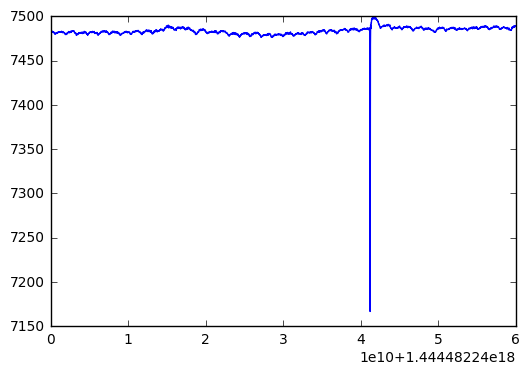

In [11]:
x = [item[0] for item in values]
y = [item[1] for item in values]
plt.clf()
plt.plot(x,y)

Manipulating data in terms of Python lists and tuples is simple, straightforward, and requires little-to-no knowledge outside of Python's builtins. However, once we start doing even slightly complex operations on these data, we will run into issues of performance and readability. For example, lets pull a statistical query for this same range of data at a reasonable point width and make a plot of the min/max/mean of the L1 MAG stream

[{'count': 129L, 'mean': 7482.865427416425, 'max': 7484.56689453125, 'min': 7480.08203125, 'time': 1444482239202066432}, {'count': 128L, 'mean': 7481.543849945068, 'max': 7482.61279296875, 'min': 7479.83544921875, 'time': 1444482240275808256}]


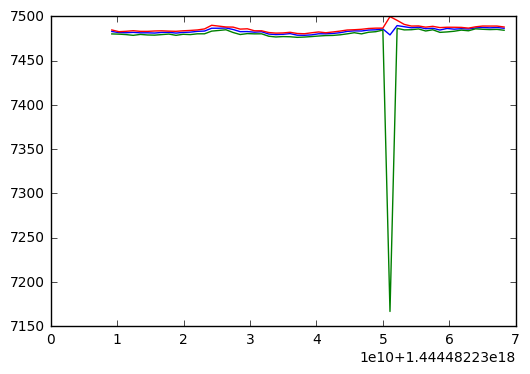

In [12]:
stats_values = context.queryStatisticalValues(l1mag_uuid, start, end, 30)[0]
print stats_values[:2]
times = [item['time'] for item in stats_values]
means = [item['mean'] for item in stats_values]
mins = [item['min'] for item in stats_values]
maxs = [item['max'] for item in stats_values]
plt.plot(times,means)
plt.plot(times,mins)
plt.plot(times,maxs)

#### Using Pandas

What now if we wanted to just pull out the second or two surrounding the sag? Or find all values greater than some threshold? Or between two timestamps? What if we wanted to mask the timeseries by the LSTATE stream which indicates whether or not an error was found with the uPMU? What if we wanted to resample the data or realign it?

All of these operations are possible using Python builtins, but the expression of these operations is *cleaner* and more performant using a Python data framework such as numpy or Pandas. Here, I'll be using Pandas, but Pandas DataFrames and Series can be easily converted to/from numpy data structures if that's what you are familiar with

In [13]:
# The 'from_records` constructor interprets a tuple as a 'row'
df = pd.DataFrame.from_records(values)
df.head() # head shows us the first few rows of the DataFrame so we can see what it looks like

,0,1
0,1444482240000000000,7483.397949
1,1444482240008333333,7483.428711
2,1444482240016666666,7483.529297
3,1444482240025000000,7483.476562
4,1444482240033333333,7483.171875


We see now the structure of our DataFrame: we have a column "0" and a column "1" representing the timestamp and value of each of the raw readings. Let's rename the columns to something more descriptive

In [14]:
df.columns = ['timestamp','value']
df.head()

,timestamp,value
0,1444482240000000000,7483.397949
1,1444482240008333333,7483.428711
2,1444482240016666666,7483.529297
3,1444482240025000000,7483.476562
4,1444482240033333333,7483.171875


In [15]:
def fetch_raw_data(uuid, start, end):
    values = context.queryStandardValues(uuid, start, end)
    df = pd.DataFrame.from_records(values[0])
    df.columns = ['timestamp','value']
    df = df.set_index(pd.to_datetime(df.pop('timestamp'),unit='ns'))
    return df
def fetch_stats_data(uuid, start, end, width):
    values = context.queryStatisticalValues(uuid, start, end, width)
    df = pd.DataFrame.from_records(values[0])
    df = df.set_index(pd.to_datetime(df.pop('time'),unit='ns'))
    return df

## Data Cleaning and Transformation

Once we get the raw data from BtrDB into a pandas DataFrame, we need to massage it so its easier to work with

### Tasks to show in this section

1. Check data count, check for null values
2. Parse timestamps
3. Show how to do this both for raw data and for statistical summary data fetched from BtrDB
4. How to augment a data frame with further fetches from BtrDB:
    - how dataframe indexes work
    - make sure to check for null values in the index; can help to resample

In Pandas, indexes are generally how we address, organize and align data. By default, the indexes for a data frame are just sequential integers indicating the order of the data, but it is more helpful to have it in terms of timestamps. Next, we will set the index of our DataFrame to be the parsed timestamps. Additionally, we will use `.pop('timestamp')` to remove the timestamp column from our DataFrame at the same time.

In [16]:
df = df.set_index(pd.to_datetime(df.pop('timestamp'),unit='ns'))
df.head()

,value
timestamp,
2015-10-10 13:04:00.000000000,7483.397949
2015-10-10 13:04:00.008333333,7483.428711
2015-10-10 13:04:00.016666666,7483.529297
2015-10-10 13:04:00.025000000,7483.476562
2015-10-10 13:04:00.033333333,7483.171875


A nice thing to do when we get a DataFrame is to get some quick summary statistics to get a sense of the dataset. Luckily, Pandas makes this easy

In [17]:
df.describe()

,value
count,7200.000000
mean,7483.439750
std,9.089149
min,7166.729492
25%,7481.144287
50%,7483.316650
75%,7486.192993
max,7499.623047


When we start combining multiple streams and doing operations on them, Pandas uses the index to determine which values across columns should be grouped together for operations. This means that if the indexes are not "lined up", then the operation will result in "null" or `NaN` values, e.g.

In [18]:
df1 = pd.DataFrame([1,2,3],index=[1,3,5])
df2 = pd.DataFrame([4,5,6],index=[1,2,3])
df1+df2

,0
1,5.0
2,NaN
3,8.0
5,NaN


To avoid this when using timestamps, we can *resample* our data so that it is aligned on some known frequency (such as "50 microseconds" or "1 day". The relevant pieces of Pandas documentation are:
- http://pandas.pydata.org/pandas-docs/stable/timeseries.html#resampling
- http://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases
- General timeseries manipulation: http://pandas.pydata.org/pandas-docs/stable/timeseries.html

This type of resampling is really only needed when you are working across several timeseries streams that may not be aligned. If you are only working with a single timeseries, then this isn't really necessary.

Here, we will downsample our DataFrame to 1 microsecond

In [19]:
dd = df.resample('1U').min().dropna()
dd.describe()

,value
count,7200.000000
mean,7483.439750
std,9.089149
min,7166.729492
25%,7481.144287
50%,7483.316650
75%,7486.192993
max,7499.623047


Now lets fetch another timeseries for the same window of time and merge it into this Pandas DataFrame. We should rename the columns so that they are more descriptive as well.

In [20]:
dd.columns = ['l1_mag']
start = date_to_nanoseconds('10 October 2015 1:04pm')
end = date_to_nanoseconds('10 October 2015 1:05pm')
new_df = fetch_raw_data(l2mag_uuid, start, end)
new_dd = new_df.resample('1U').min().dropna()
new_dd.columns = ['l2_mag']

We now use Pandas [merge](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) function to combine the two DataFrames based on their now shared data indexes. We can do a basic sanity check on the results by plotting them.

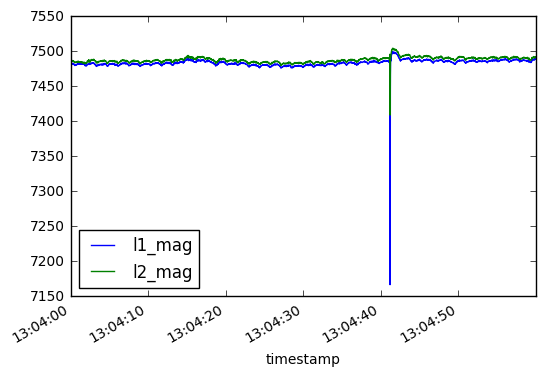

In [21]:
merged = pd.merge(dd, new_dd, left_index=True, right_index=True)
merged.plot()

We can also easily write a method that pulls statistical data from BtrDB and places it in a dataframe

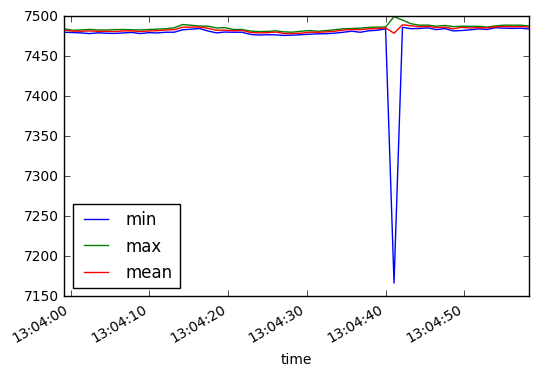

In [22]:
stats_df = fetch_stats_data(l1mag_uuid, start, end, 30)
stats_df[['min','max','mean']].plot()

## Data Manipulation in Pandas

Now that the Pandas data is useful and 'clean' (to the best of our knowledge), we next learn how to do some basic operations on the DataFrame data structure.

### Tasks to show in this section

1. How to add/subtract/etc data frames
    - also include the `.apply()` method
    - iterate through data frames
2. How to slice/filter data frames:
    - select data w/n some time range
    - find values above/below some threshold
    


In [23]:
merged.head()

,l1_mag,l2_mag
timestamp,,
2015-10-10 13:04:00.000000,7483.397949,7487.836914
2015-10-10 13:04:00.008333,7483.428711,7487.605469
2015-10-10 13:04:00.016666,7483.529297,7487.623047
2015-10-10 13:04:00.025000,7483.476562,7487.585938
2015-10-10 13:04:00.033333,7483.171875,7487.355469


Pandas DataFrames are a collection of named [Series](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html), which are essentially a kind of `numpy.array` or `list` with their own set of methods; the primary difference is the addition of an index, which we've covered before.

As we've seen above, we access individual columns of a DataFrame `df` by treating the columns like a dictionary, e.g. `df['column name']`. From here, we can add/subtract/divide/multiply/etc these Series to prototype whatever kind of behavior we want.

Let's start by characterizing the differences between the L1 and L2 MAG streams:

In [24]:
diff = merged['l2_mag'] - merged['l1_mag']
diff.describe()

count    7200.000000
mean        4.478562
std         6.506403
min         0.759766
25%         3.969727
50%         4.283203
75%         4.611816
max       250.501953
dtype: float64

Let's pull the `LSTATE` stream and use it as a reverse mask to remove sections of our data stream that may have GPS lock errors.

In [25]:
lstate_path = "/REFSET/LBNL/a6_bus1/LSTATE"
lstate_uuid = uuid_from_path(lstate_path)
mask_df = fetch_raw_data(lstate_uuid, start,end)
mask_df = mask_df.resample('1U').min().dropna()
merged_with_mask = pd.merge(merged, mask_df, left_index=True, right_index=True)
merged_with_mask.head()

,l1_mag,l2_mag,value
timestamp,,,
2015-10-10 13:04:00.000000,7483.397949,7487.836914,0.0
2015-10-10 13:04:00.008333,7483.428711,7487.605469,0.0
2015-10-10 13:04:00.016666,7483.529297,7487.623047,0.0
2015-10-10 13:04:00.025000,7483.476562,7487.585938,0.0
2015-10-10 13:04:00.033333,7483.171875,7487.355469,0.0


In [26]:
merged_with_mask.describe()

,l1_mag,l2_mag,value
count,7200.000000,7200.000000,7200.000000
mean,7483.439750,7487.918312,0.066667
std,9.089149,4.161794,0.512112
min,7166.729492,7409.046875,0.000000
25%,7481.144287,7485.238770,0.000000
50%,7483.316650,7487.510254,0.000000
75%,7486.192993,7490.523926,0.000000
max,7499.623047,7504.643066,4.000000


There's actually a problem with the data above; the LSTATE stream we pulled in has a minimum value of -3, which doesn't make sense for a 1-0 mask. We're going to have to go in and clean the data. To do this, we will learn about Pandas filters.

We will start with some basic thresholding (return rows of a DataFrame that are greater than some constant). In the following, we make sure to address the 'value' column directly, though there are several "flavors" of filtering. When the name of a DataFrame is used by itself, the filter applies to all rows at once:

```python
mask_df.count() # returns the counts of each column in mask_df
mask_df['a'].count() # returns the count of the column 'a'
mask_df[mask_df > 0] # returns all rows of mask_df where all values of mask_df are greater than 0
mask_df[mask_df['a'] > 0] # returns all rows of mask-df where the value in column 'a' is greater than 0
greater_than_zero = mask_df['a'] > 0 # creates a boolean vector where entry is True if 'a' is greater than 0
mask_df['a'][greater_than_zero] # returns all rows of mask_df column 'a' where "greater_than_zero" is True
```

In [27]:
print mask_df['value'].count()
print mask_df['value'][mask_df['value'] > 1].count()

7200
120


We can see that there are 120 values in which our mask is greater than 1. We have two options; either we remove those values from the mask, or we truncate them to 1. I will show how to do both.

For simplicity, lets first create a boolean vector that allows us to address only the values we want to keep

In [28]:
keep_mask = (mask_df['value'] == 0) | (mask_df['value'] == 1)
keep_mask.head()

timestamp
2015-10-10 13:04:00.000000    True
2015-10-10 13:04:00.008333    True
2015-10-10 13:04:00.016666    True
2015-10-10 13:04:00.025000    True
2015-10-10 13:04:00.033333    True
Name: value, dtype: bool

Here, we use the construction

```python
(mask_df['value'] == 0) | (mask_df['value'] == 1)
```

To take the logical `or` of the two mask vectors; the result is a single vector which is True if the value is either 0 or 1. Pandas uses the bitwise or symbol (`|`) to accomplish this.

This operation will gives us a Series. It is important that this is still a Pandas Series because this series of operations *preserves the DataFrame indexes*, which means that we can combine these DataFrames and Series later without worrying how our data will line up.

To **remove** the values from the `mask_df` DataFrame that do not meet our filter, we use the boolean vector to "index" into the DataFrame

In [29]:
mask_with_garbaged_removed = mask_df[keep_mask]
mask_with_garbaged_removed.describe()

,value
count,7080.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


To **change** the garbage values by truncating them to 1, we can do something similar

In [30]:
change_mask = (mask_df['value'] != 0) & (mask_df['value'] != 1)
mask_with_garbage_clipped = mask_df.copy()
mask_with_garbage_clipped[change_mask] = 1
mask_with_garbage_clipped.describe()

,value
count,7200.000000
mean,0.016667
std,0.128028
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Now, we can apply the mask to the `merged` data frame to remove possibly garbage readings.

In [31]:
filtered = merged[mask_with_garbage_clipped['value'] == 0]
filtered.describe() # we've removed 120 possibly garbage values

,l1_mag,l2_mag
count,7080.000000,7080.000000
mean,7483.428221,7487.905801
std,9.164163,4.192013
min,7166.729492,7409.046875
25%,7481.103027,7485.188354
50%,7483.280518,7487.448242
75%,7486.229370,7490.560059
max,7499.623047,7504.643066


Now that we have a relatively clean dataset, we can finally take a look at isolating the interesting event we have.

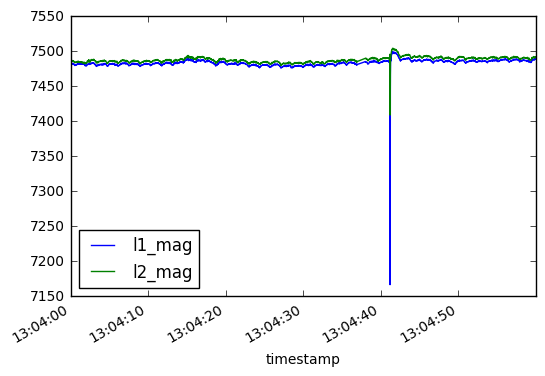

In [32]:
filtered.plot()

In [33]:
l1_mag_min_timestamp = filtered['l1_mag'].argmin()
print "L1 MAG minimum happens at", l1_mag_min_timestamp
after = l1_mag_min_timestamp + pd.Timedelta(milliseconds=100)
before = l1_mag_min_timestamp - pd.Timedelta(milliseconds=100)

L1 MAG minimum happens at 2015-10-10 13:04:41.216666


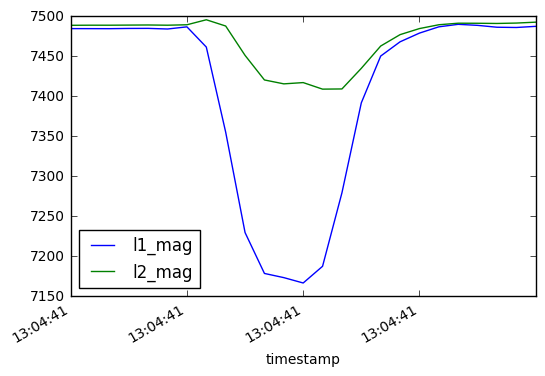

In [34]:
merged.ix[before:after].plot() # use .ix to filter on the index

#### Some nifty data viz

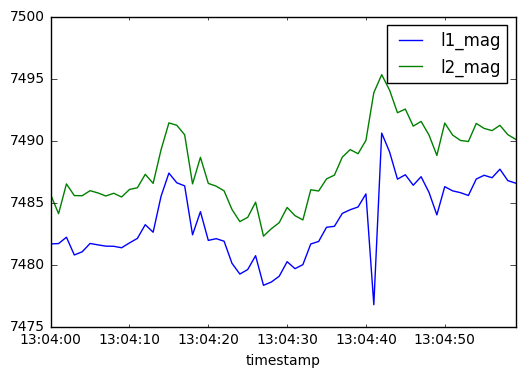

In [35]:
# Sampling
merged.resample('1S').mean().plot()

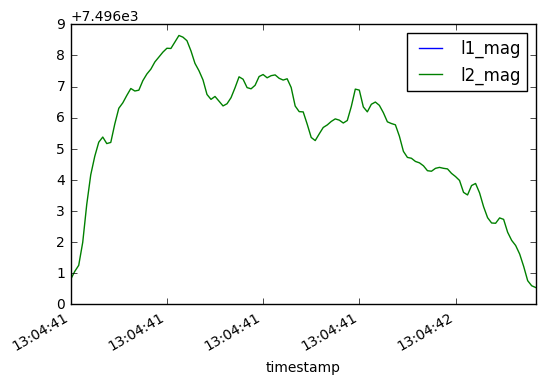

In [36]:
# plotting outlier segments of the chunk
outlier_index = (merged > (merged.mean()+2*merged.std()))
merged[outlier_index].dropna(how='all').plot()

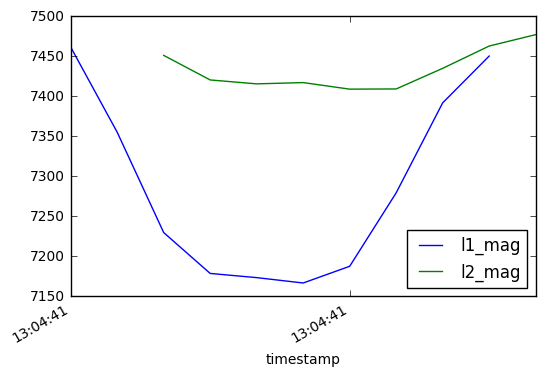

In [37]:
outlier_index = (merged < (merged.mean()-2*merged.std()))
merged[outlier_index].dropna(how='all').plot()